In [16]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import sklearn as sk

In [32]:
import seaborn as sns
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn_extra.cluster import KMedoids
from sklearn.neighbors import NearestNeighbors
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.metrics import silhouette_score
from yellowbrick.cluster import SilhouetteVisualizer
from yellowbrick.cluster import KElbowVisualizer
from sklearn.mixture import GaussianMixture as GMM
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import AgglomerativeClustering

# Clustering 

## 1. Obtention d’une classification des variables ”Tx_xh_Rx”

In [18]:
data = pd.read_csv("Data_Etudiants_2023.txt", sep=";")

In [19]:
scaler = StandardScaler();

data_transforme = data.T
scaler.fit(data_transforme);
data_transforme = scaler.transform(data_transforme)

pca = PCA(n_components = 10)
pca.fit(data_transforme)
acp = pca.fit_transform(data_transforme)

In [20]:
acp.shape

(36, 10)

In [21]:
np.cumsum(pca.explained_variance_ratio_)

array([0.80670961, 0.88697656, 0.90724463, 0.9245233 , 0.93874762,
       0.94966394, 0.95710384, 0.9620022 , 0.96615427, 0.96993311])

In [22]:
# 3 composantes explique 90% d'inertie
coord = pd.DataFrame(acp[:,0:3],columns = ['Dim 1', 'Dim 2', 'DIm 3'])

### 1.1 K-means

In [23]:
InertieIntra = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0);
    kmeans.fit(coord);
    InertieIntra.append(kmeans.inertia_);
    
aux = pd.DataFrame({"K" : range(2, 10),
                    "InertieIntra" : InertieIntra})
fig = px.line(aux, x='K', y='InertieIntra',labels={'x':'Number of clusters', 'y':'Inertie Intra'},markers=True)
fig.show()

In [24]:


silhouette_coefficients = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0);
    kmeans.fit(coord);
    score = silhouette_score(coord, kmeans.labels_);
    silhouette_coefficients.append(score);

aux = pd.DataFrame({"K" : range(2, 10),
                    "Silhouette" : silhouette_coefficients})
fig = px.line(aux, x='K', y='Silhouette',labels={'x':'Number of clusters', 'y':'Silhouette'},markers=True)
fig.show() 

In [25]:
# on retient 2 classes

kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(coord)

KMeans(n_clusters=2, n_init=10, random_state=0)

In [26]:
# Représentation dans le premier plan de l’ACP :
pca_df = pd.DataFrame({
    "Dim1" : acp[:,0], 
    "Dim2" : acp[:,1],
    "Kmeans3" : pd.Categorical(kmeans.labels_)
})
fig = px.scatter(pca_df,x="Dim1", y="Dim2", color="Kmeans3", symbol="Kmeans3")
fig.show()

In [27]:
# effectifs par classe
pd.crosstab(kmeans.labels_,"freq")

col_0,freq
row_0,
0,16
1,20


SilhouetteVisualizer(ax=<AxesSubplot: >, colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, n_init=10, random_state=0))

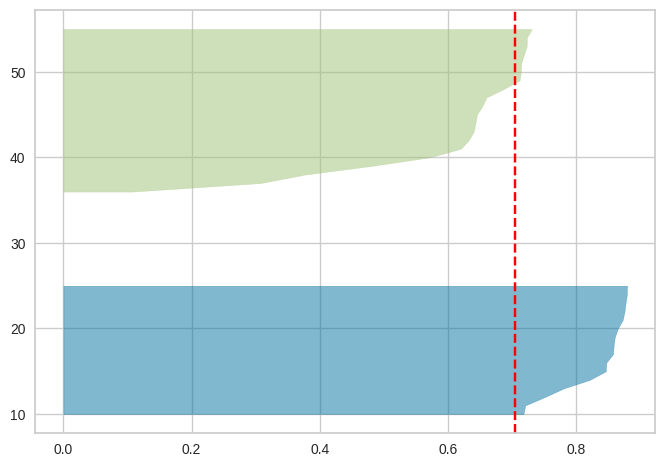

In [28]:
kmeansopt = KMeans(2,init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0);
visualizer = SilhouetteVisualizer(kmeansopt, colors='yellowbrick');
visualizer.fit(coord)

## 1.2 Classification hiérarchique avec la mesure de Ward

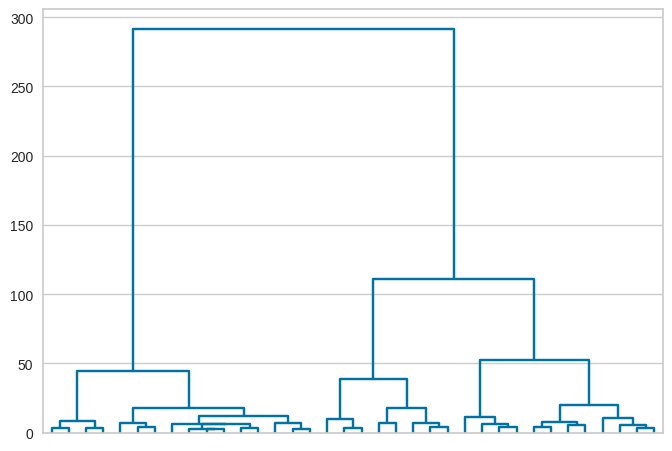

In [29]:
hward=linkage(coord,method='ward')
dendrogram(hward,no_labels=True,color_threshold=0);  
plt.show()

KElbowVisualizer(ax=<AxesSubplot: >,
                 estimator=AgglomerativeClustering(n_clusters=9), k=(2, 10),
                 metric='calinski_harabasz', timings=False)

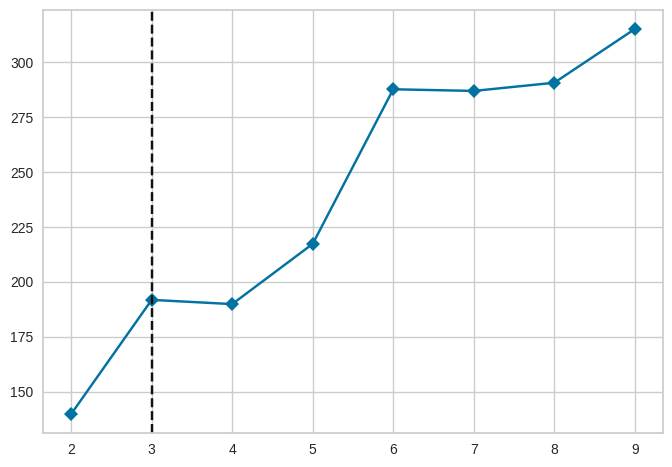

In [33]:
# On détermine la coupure avec indice de Calinski-Harabasz
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,10), metric="calinski_harabasz",timings=False);
visualizer.fit(coord)

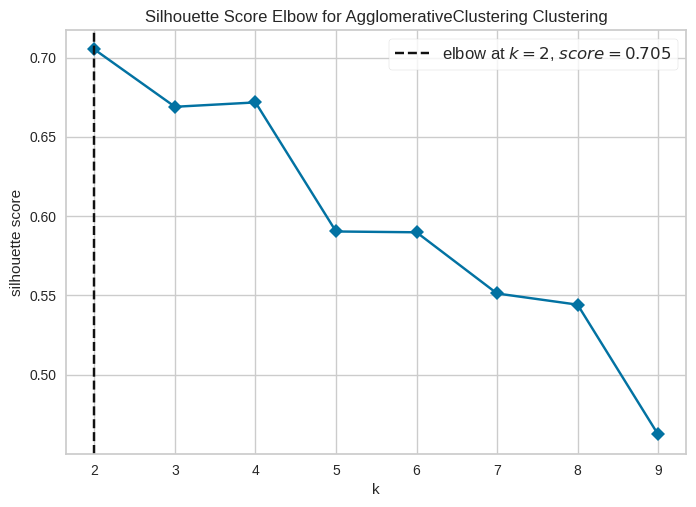

<AxesSubplot: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [34]:
# avec indice Silhouette
visualizer = KElbowVisualizer(model, k=(2,10), metric="silhouette",timings=False);
visualizer.fit(coord);
visualizer.show()

In [35]:
# on retient donc 2 ou 3 classe selon les deux indices
# on prend 3 classes par exemple
modelfin = AgglomerativeClustering(n_clusters=3, affinity='euclidean', linkage='ward')
modelfin.fit(coord)

/home/seele/anaconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



AgglomerativeClustering(affinity='euclidean', n_clusters=3)

In [36]:
# effectifs par classe
pd.crosstab(modelfin.labels_,"freq")

col_0,freq
row_0,
0,12
1,16
2,8


In [37]:
# représentation dans les plans de l'ACP
pca_df = pd.DataFrame({
    "Dim1" : acp[:,0], 
    "Dim2" : acp[:,1],
    "CAH" : pd.Categorical(modelfin.labels_)
})
fig=px.scatter(pca_df,x="Dim1", y="Dim2",color="CAH")
fig.show()

In [38]:
# la distribution en fonction de la classification
aux=coord.assign(Clust=modelfin.labels_)
sm = aux.melt(id_vars='Clust')
fig=px.box(sm,x="Clust",y="value",facet_col="variable",facet_col_wrap=3,color="Clust")
fig.show()

## 1.3 Modèle de mélange

In [39]:
Kmax = 10
K_components = np.arange(2, Kmax)

models = [GMM(K, covariance_type='full', random_state=0).fit(coord) for K in K_components]

BIC=[m.bic(coord) for m in models]
AIC=[m.aic(coord) for m in models]
ICL = [m.bic(coord) - (2*sum(np.log( np.max(m.predict_proba(coord),1) ))) for m in models]

crit = pd.DataFrame({
    "K" : np.arange(2, Kmax),
    "BIC" : BIC, 
    "AIC" : AIC,
    "ICL" : ICL,
})
critdf=pd.melt(crit, id_vars=['K'], value_vars=['BIC', 'AIC', 'ICL'])

import plotly.express as px
fig = px.line(critdf, x='K', y='value', color='variable')
fig.show()

In [40]:
# selon les 3 critères, on retient 9 classes, (ce qui n'a pas l'air correct ?
BIC=[m.bic(coord) for m in models]
u=np.argmin(BIC)
probapost = models[u].predict_proba(coord)
labels=models[u].fit_predict(coord)   
probamax=[np.max(probapost[x,:]) for x in range(len(coord))]

pd.crosstab(labels,"freq")

col_0,freq
row_0,
0,12
1,4
2,3
3,4
4,4
5,3
6,2
7,1
8,3


## 2. Obtention d’une classification des gènes ayant des profils d’expression similaires (co-exprimés) dans les différentes conditions

In [41]:
data = pd.read_csv("Data_Etudiants_2023.txt", sep=";")

scaler = StandardScaler();

scaler.fit(data);
data = scaler.transform(data)

pca = PCA(n_components = 10)
pca.fit(data)
acp = pca.fit_transform(data)

In [42]:
acp.shape

(1615, 10)

In [43]:
np.cumsum(pca.explained_variance_ratio_)

array([0.59103461, 0.70223651, 0.76585195, 0.82448606, 0.86181919,
       0.88978951, 0.91544184, 0.93004242, 0.94358643, 0.95520684])

In [44]:
# 7 composantes explique 90% d'inertie
coord2 = pd.DataFrame(acp[:,0:7],columns = ['Dim 1', 'Dim 2', 'Dim 3', 'Dim 4', 'Dim 5', 'Dim 6', 'Dim 7'])

## 2.1 k-means

In [45]:
InertieIntra = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0);
    kmeans.fit(coord2);
    InertieIntra.append(kmeans.inertia_);
    
aux = pd.DataFrame({"K" : range(2, 10),
                    "InertieIntra" : InertieIntra})
fig = px.line(aux, x='K', y='InertieIntra',labels={'x':'Number of clusters', 'y':'Inertie Intra'},markers=True)
fig.show()

In [46]:
silhouette_coefficients = []
for k in range(2, 10):
    kmeans = KMeans(n_clusters=k,init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0);
    kmeans.fit(coord2);
    score = silhouette_score(coord2, kmeans.labels_);
    silhouette_coefficients.append(score);

aux = pd.DataFrame({"K" : range(2, 10),
                    "Silhouette" : silhouette_coefficients})
fig = px.line(aux, x='K', y='Silhouette',labels={'x':'Number of clusters', 'y':'Silhouette'},markers=True)
fig.show() 

In [47]:
# on retient 2 classes
kmeans = KMeans(n_clusters = 2, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
kmeans.fit(coord2)

KMeans(n_clusters=2, n_init=10, random_state=0)

In [48]:
# Représentation dans le premier plan de l’ACP :
pca_df = pd.DataFrame({
    "Dim1" : acp[:,0], 
    "Dim2" : acp[:,1],
    "Kmeans3" : pd.Categorical(kmeans.labels_)
})
fig = px.scatter(pca_df,x="Dim1", y="Dim2", color="Kmeans3", symbol="Kmeans3")
fig.show()

In [49]:
# effectifs par classe
pd.crosstab(kmeans.labels_,"freq")

col_0,freq
row_0,
0,773
1,842


SilhouetteVisualizer(ax=<AxesSubplot: >, colors='yellowbrick',
                     estimator=KMeans(n_clusters=2, n_init=10, random_state=0))

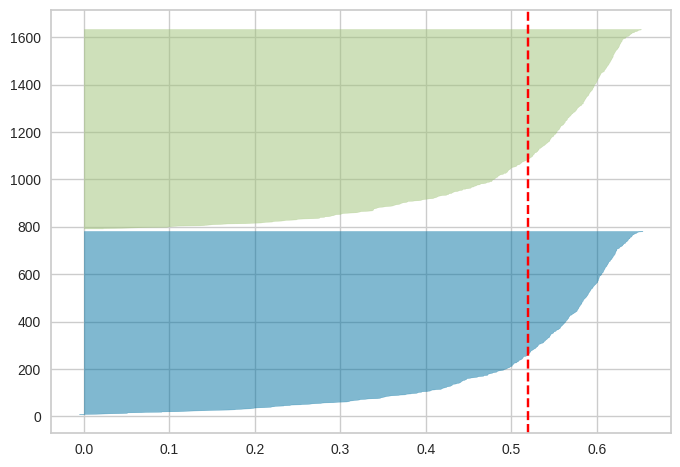

In [50]:
kmeansopt = KMeans(2,init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0);
visualizer = SilhouetteVisualizer(kmeansopt, colors='yellowbrick');
visualizer.fit(coord2)

## 2.2 Classification hiérarchique avec la mesure de Ward

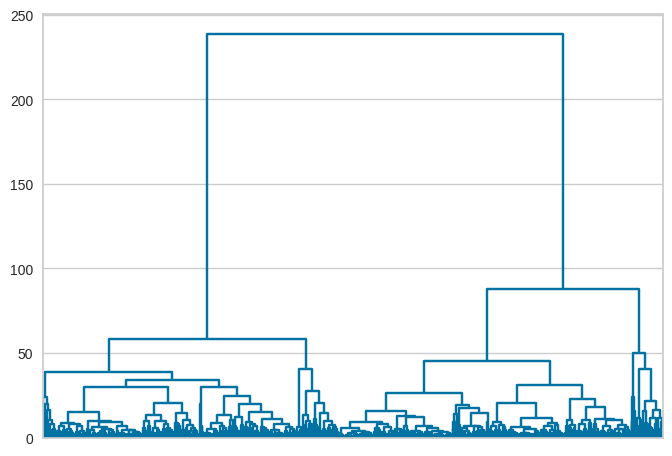

In [51]:
hward=linkage(coord2,method='ward')
dendrogram(hward,no_labels=True,color_threshold=0);  
plt.show()

KElbowVisualizer(ax=<AxesSubplot: >,
                 estimator=AgglomerativeClustering(n_clusters=9), k=(2, 10),
                 metric='calinski_harabasz', timings=False)

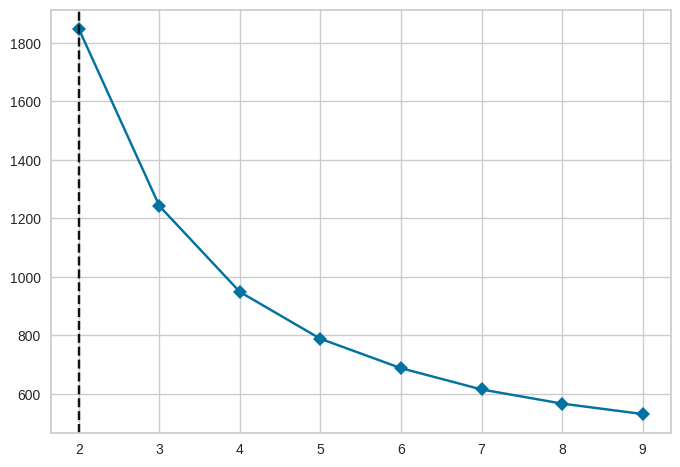

In [52]:
# On détermine le nombre de classe avec indice de Calinski-Harabasz
model = AgglomerativeClustering()
visualizer = KElbowVisualizer(model, k=(2,10), metric="calinski_harabasz",timings=False);
visualizer.fit(coord2)

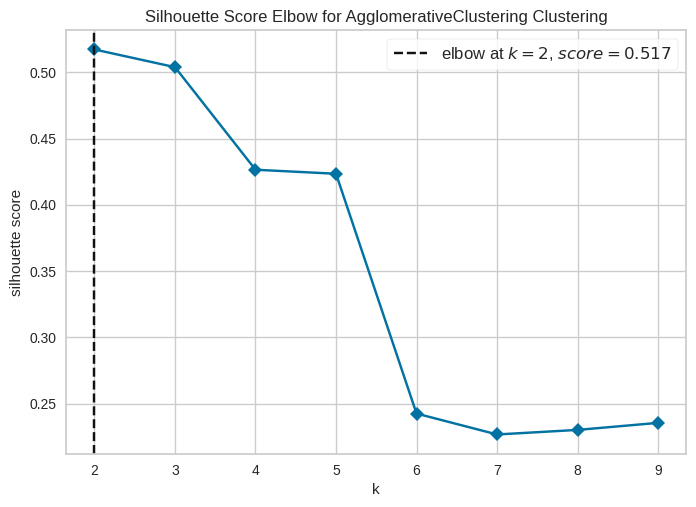

<AxesSubplot: title={'center': 'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [53]:
# avec indice Silhouette
visualizer = KElbowVisualizer(model, k=(2,10), metric="silhouette",timings=False);
visualizer.fit(coord2);
visualizer.show()

In [54]:
# on retient donc 2 classes selon les deux indices
modelfin = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage='ward')
modelfin.fit(coord2)

/home/seele/anaconda3/envs/pyenv/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



AgglomerativeClustering(affinity='euclidean')

In [55]:
# effectifs par classe
pd.crosstab(modelfin.labels_,"freq")

col_0,freq
row_0,
0,843
1,772


In [56]:
# représentation dans les plans de l'ACP
pca_df = pd.DataFrame({
    "Dim1" : acp[:,0], 
    "Dim2" : acp[:,1],
    "CAH" : pd.Categorical(modelfin.labels_)
})
fig=px.scatter(pca_df,x="Dim1", y="Dim2",color="CAH")
fig.show()

## 2.3 Modèle de mélange

In [57]:
Kmax = 10
K_components = np.arange(2, Kmax)

models = [GMM(K, covariance_type='full', random_state=0).fit(coord2) for K in K_components]

BIC=[m.bic(coord2) for m in models]
AIC=[m.aic(coord2) for m in models]
ICL = [m.bic(coord2) - (2*sum(np.log( np.max(m.predict_proba(coord2),1) ))) for m in models]

crit = pd.DataFrame({
    "K" : np.arange(2, Kmax),
    "BIC" : BIC, 
    "AIC" : AIC,
    "ICL" : ICL,
})
critdf=pd.melt(crit, id_vars=['K'], value_vars=['BIC', 'AIC', 'ICL'])

fig = px.line(critdf, x='K', y='value', color='variable')
fig.show()

In [58]:
# selon les critères BIC et ICL, on retient 6 classes
u=np.argmin(BIC)
probapost = models[u].predict_proba(coord2)
labels=models[u].fit_predict(coord2)   
probamax=[np.max(probapost[x,:]) for x in range(len(coord2))]

# effectifs
pd.crosstab(labels,"freq")

col_0,freq
row_0,
0,72
1,318
2,393
3,138
4,295
5,399


In [59]:
# On plot sur les 2 premiers plans de l'ACP
df = pd.DataFrame({
    "X" : coord2['Dim 1'],
    "Y" : coord2['Dim 2'],
    "labels" : pd.Categorical(labels)
})
df.labels=pd.Categorical(labels)
fig = px.scatter(df,x="X", y="Y", color="labels", symbol="labels")
fig.show()

In [60]:
# boxplot des probamax
aux=pd.DataFrame({'probamax':probamax,'labels':labels},columns = ['probamax', 'labels'])

fig = px.box(aux, x="labels", y="probamax")
fig.show()

In [61]:
data = pd.read_csv("Data_Etudiants_2023.txt", sep=";")
data_quali = data
data_quali[data > 1] = 1
data_quali[data < -1] = -1
data_quali[(data > -1) & (data < 1)] = 0
data_quali = pd.DataFrame(data = data_quali, columns = data.columns.values)

In [62]:
# classification de k-means
pd.crosstab(kmeansopt.labels_,data_quali["T3_6h_R2"])

T3_6h_R2,-1.0,1.0
row_0,,
0,761,12
1,3,839


In [63]:
# classification hiérarchique avec critère silhouette
pd.crosstab(modelfin.labels_,data_quali["T3_6h_R2"])

T3_6h_R2,-1.0,1.0
row_0,,
0,0,843
1,764,8


In [64]:
# On compare ces deux modèles (K-means et CAH), ils sont très proches
adjusted_rand_score(modelfin.labels_,kmeansopt.labels_)

0.9680411982813028

In [65]:
# classification modèle de mélange
pd.crosstab(pd.Categorical(labels),data_quali["T3_6h_R2"])

T3_6h_R2,-1.0,1.0
row_0,,
0,72,0
1,0,318
2,393,0
3,4,134
4,295,0
5,0,399
